In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#pip install prophet

In [ ]:
# 라이브러리
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from tqdm import tqdm

# TS test & plot
import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# 이상치 탐지 모델
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import IsolationForest
from prophet import Prophet
from sklearn.linear_model import LogisticRegression


# 모델 평가 지표
from sklearn.metrics import f1_score, recall_score, matthews_corrcoef, accuracy_score, precision_score, confusion_matrix

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 폰트 깨짐 방지
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')

#### 데이터 불러오기

In [ ]:
data_iter = pd.read_csv('/content/drive/MyDrive/삼성화재&Postech 데이터 리스크 /데이터/기상/기상보간iter.csv', encoding='UTF-8')
data_linear = pd.read_csv('/content/drive/MyDrive/삼성화재&Postech 데이터 리스크 /데이터/기상/기상보간linear.csv', encoding='UTF-8')

In [ ]:
data_iter['Year'] = data_iter['일시'].str.split('-').str[0].astype('int')
data_linear['Year'] = data_linear['일시'].str.split('-').str[0].astype('int')

In [ ]:
data_iter_index = data_iter.set_index('일시').copy()
data_linear_index = data_linear.set_index('일시').copy()

In [ ]:
target = ['최저기온(°C)','지점명','Year','최고기온(°C)']
data_iter_index_cold = data_iter_index[target]

In [ ]:
## 최저기온 분류
target = ['최저기온(°C)','지점명','Year','최고기온(°C)','일시']

data_iter_cold = data_iter[target].copy()
data_linear_cold = data_linear[target].copy()


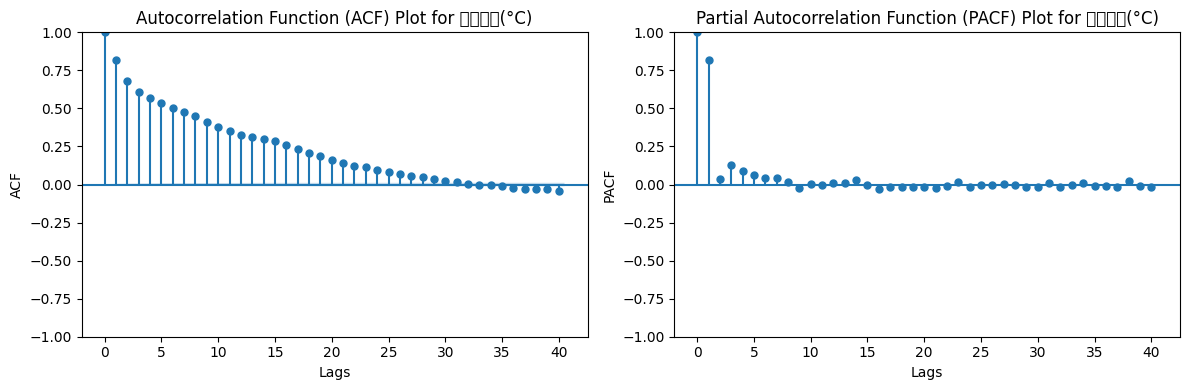

In [ ]:
# ACF PACF --> 여기까지
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming location_data contains your time series data with '최저기온(°C)' column
series = data_iter_cold['최저기온(°C)']

# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot
plot_acf(series, lags=40, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('ACF')
ax1.set_title('Autocorrelation Function (ACF) Plot for 최저기온(°C)')

# PACF plot
plot_pacf(series, lags=40, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('PACF')
ax2.set_title('Partial Autocorrelation Function (PACF) Plot for 최저기온(°C)')

plt.tight_layout()
plt.show()

#### 시각화

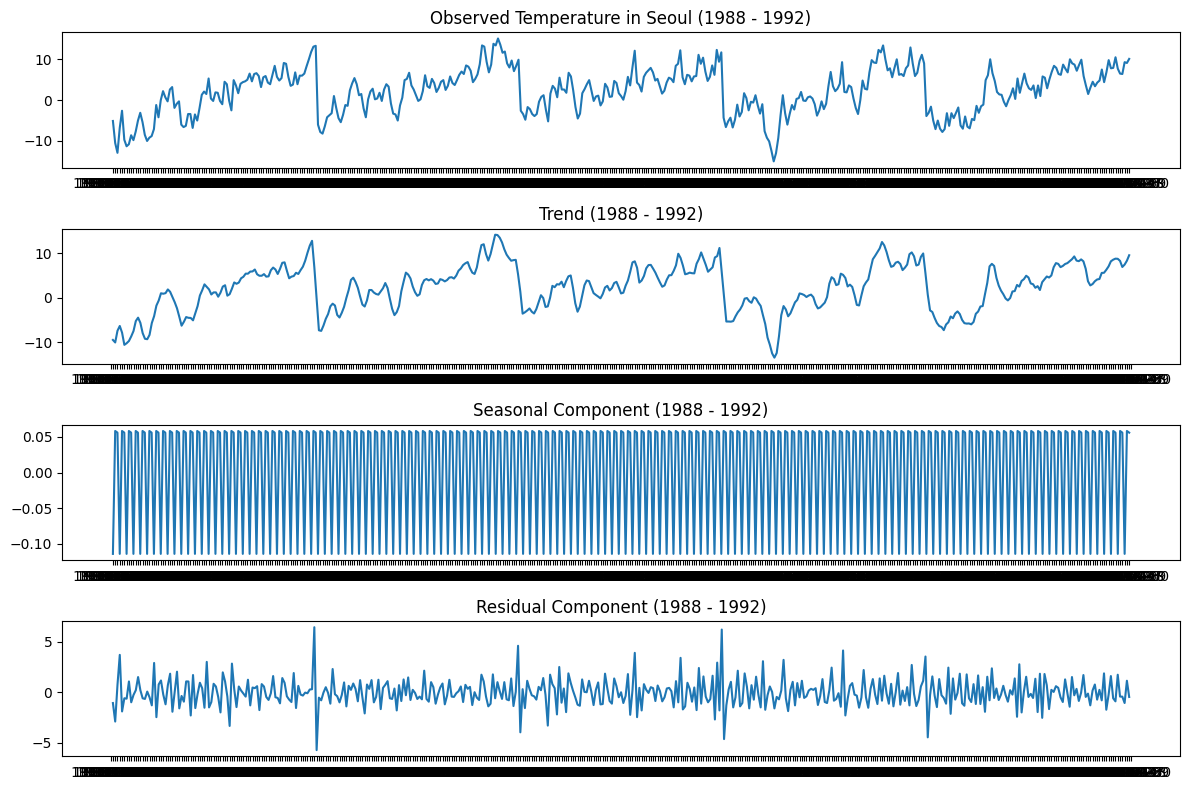

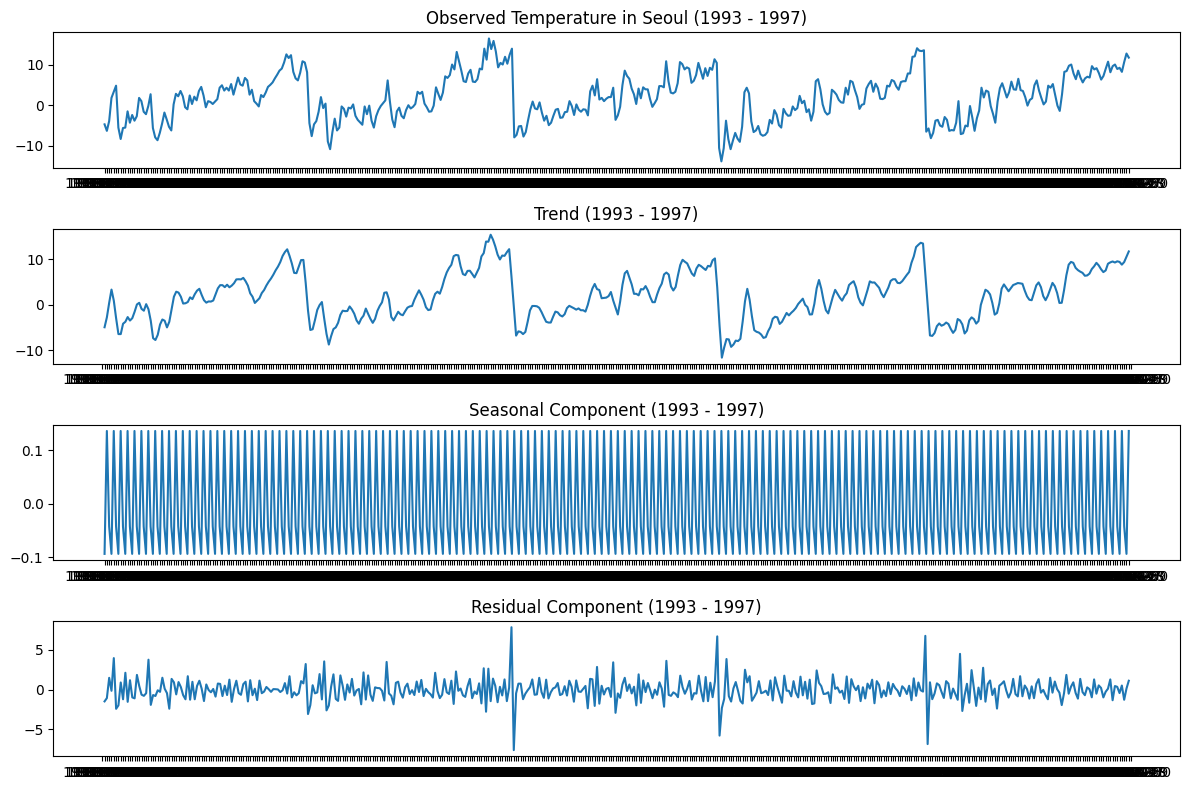

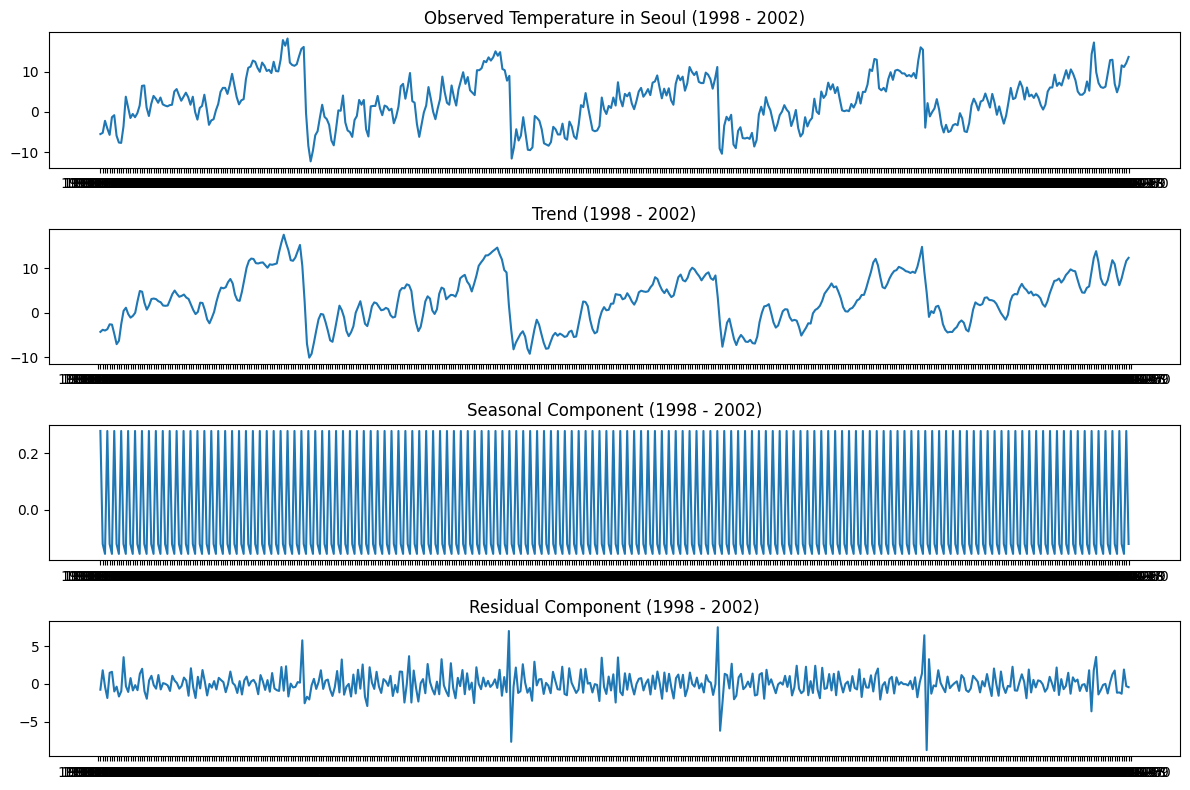

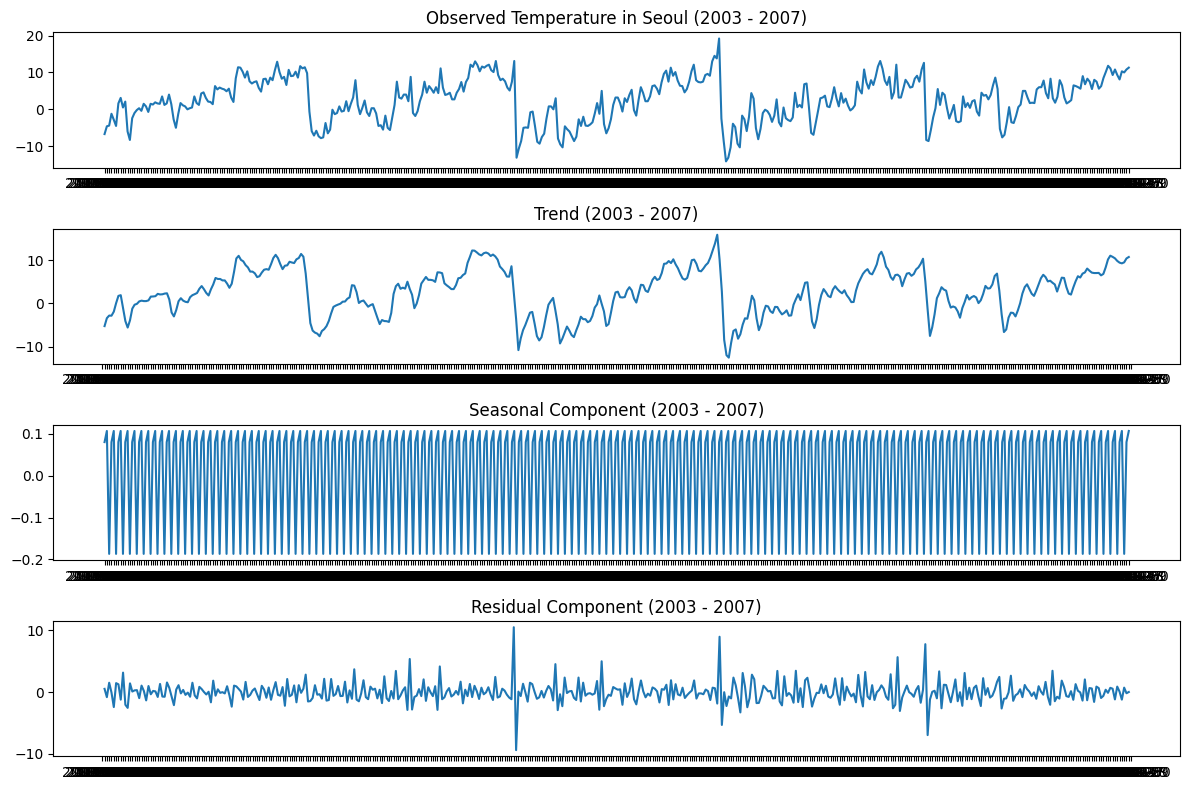

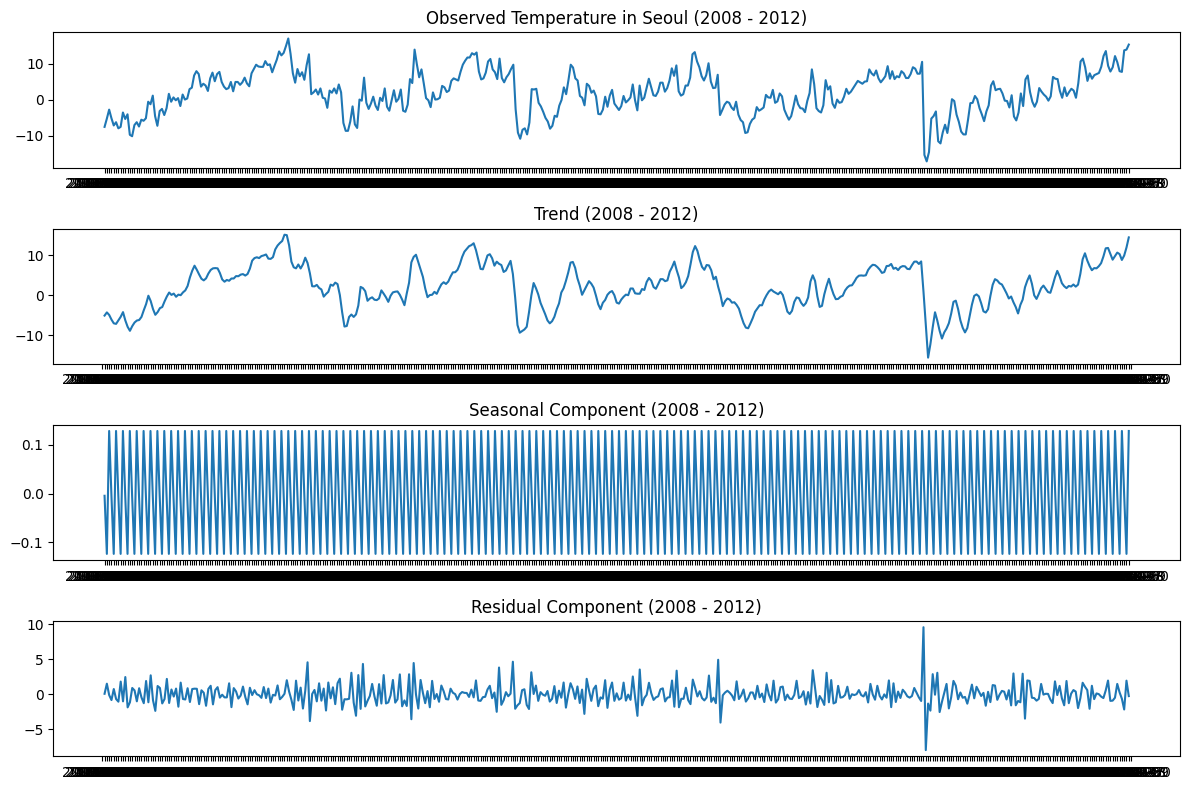

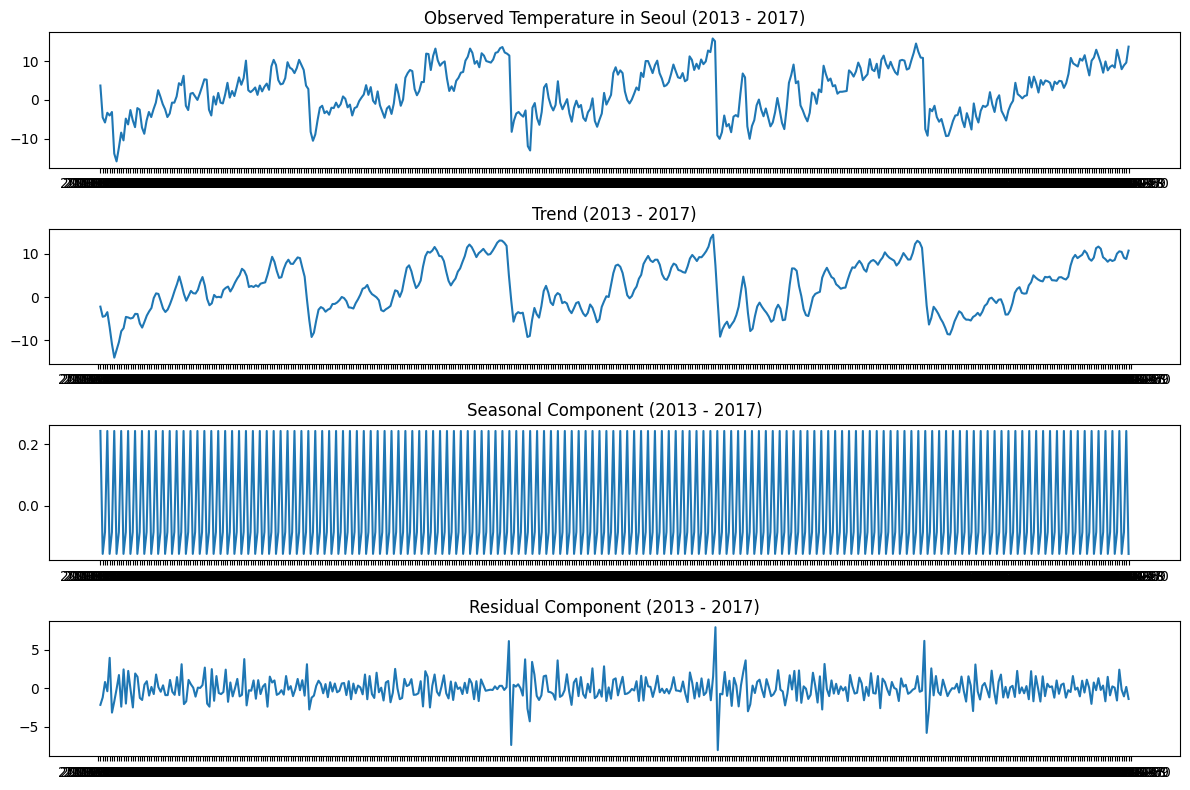

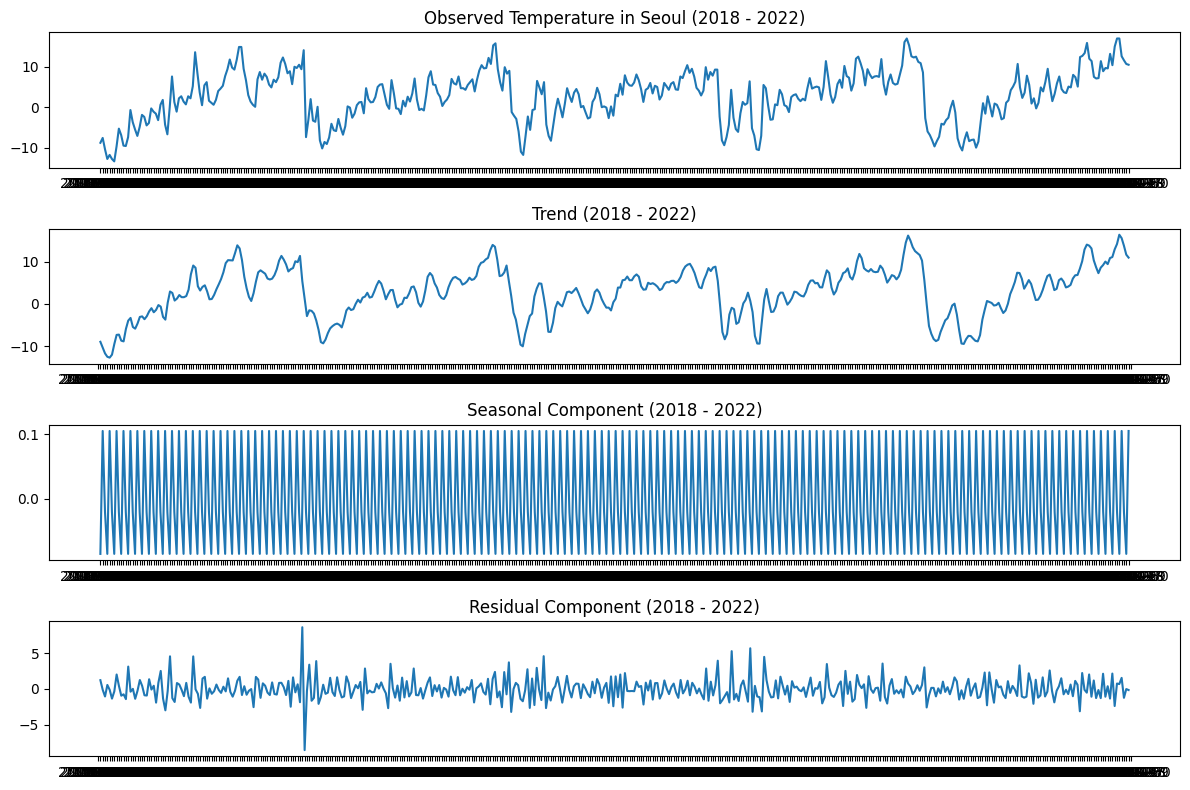

In [ ]:
## 최저기온의 trend/seasonality/ residual plot
def plot_seasonal_decomposition_by_5_years(data, start_year, end_year, period=3):
    results = []
    original_start_year = start_year

    while start_year <= end_year - 5:
        current_data = data['최저기온(°C)'][(data['Year'] >= start_year) & (data['Year'] < start_year + 5)
                                           & (data['지점명'] == '서울')]
        result = seasonal_decompose(current_data, model='additive', period=period)
        results.append(result)
        start_year += 5

    for i, result in enumerate(results):
        start_year_i = original_start_year + i * 5
        end_year_i = start_year_i + 4

        plt.figure(figsize=(12, 8))
        plt.subplot(4, 1, 1)
        plt.plot(result.observed)
        plt.title(f'Observed Temperature in Seoul ({start_year_i} - {end_year_i})')

        plt.subplot(4, 1, 2)
        plt.plot(result.trend)
        plt.title(f'Trend ({start_year_i} - {end_year_i})')

        plt.subplot(4, 1, 3)
        plt.plot(result.seasonal)
        plt.title(f'Seasonal Component ({start_year_i} - {end_year_i})')

        plt.subplot(4, 1, 4)
        plt.plot(result.resid)
        plt.title(f'Residual Component ({start_year_i} - {end_year_i})')

        plt.tight_layout()
        plt.show()

plot_seasonal_decomposition_by_5_years(data_iter_index_cold, start_year=1988, end_year=2023, period=3)

In [ ]:
## 최저기온의 ACF / PACF --> ( ) 시계열
def plot_acf_pacf(data, lags=40):
    columns = data.columns

    fig, axes = plt.subplots(len(columns) * 2, 1, figsize=(10, 4 * len(columns)))

    for i, column in enumerate(columns):

        plot_acf(data[column], lags=lags, ax=axes[i * 2])
        axes[i * 2].set_title(f'ACF for {column}')

        plot_pacf(data[column], lags=lags, ax=axes[i * 2 + 1])
        axes[i * 2 + 1].set_title(f'PACF for {column}')

    plt.tight_layout()
    plt.show()

plot_acf_pacf(data_iter_cold.drop(['지점명','Year'],axis=1), lags=40)

In [ ]:
adfuller_test = adfuller(data_iter_cold['최저기온(°C)'], autolag="AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

In [ ]:
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -12.133456668960156
p-value: 1.7147789953341817e-22


In [ ]:
# 정상성 검정
adfuller_test = adfuller(data_iter_cold['최저기온(°C)'], autolag="AIC")
for column in data_iter_cold.drop(['지점명', 'Year', '일시'], axis = 1).columns:
  adfuller_test = adfuller(data_iter_cold[column], autolag="AIC")
  print(f'Column: {column}')
  print("ADF test statistic: {}".format(adfuller_test[0]))
  print("p-value: {}".format(adfuller_test[1]))
  print('-' * 30)

#### Threshold 결정
- 이상기온(異常氣溫)이란 기온이 30년 평년(1991~2020년)에 비해 현저히 높거나 낮은 수치를 나타내는 현상인데 평년기온에서 10퍼센타일 미만, 90퍼센타일 초과로 정의함
- 퍼센타일은 평년의 기온(해당일을 포함하는 5일평균)과 비교하여 낮은 순서대로 몇 번째인지 나타내는 백분위수로 이상기온을 정의하는데 사용하였음
- 이상치 percent 5일 단위로 10% -> Rolling (앞에 2일 / 뒤에 2일)


뭔가 이상함 --> 수정부탁

In [ ]:
unique_locations = data_iter_index['지점명'].unique()

In [ ]:
# trend 제거
result_data_trend = pd.DataFrame()
for location in tqdm(unique_locations, desc='Processing Locations'):
    location_data = data_iter_index[data_iter_index['지점명'] == location]

    location_data['최저기온(°C)_차분'] = location_data['최저기온(°C)'].diff()
    location_data['5일이동평균'] = location_data['최저기온(°C)_차분'].rolling(window = 5, min_periods = 5).min()

    quantile_10 = location_data['5일이동평균'].quantile(0.1)
    location_data['이상기온'] = location_data['5일이동평균'].apply(lambda x: 1 if x <= quantile_10 else 0)

    result_data_trend = pd.concat([result_data_trend, location_data])

# 지역별로 이상값
(result_data_trend[result_data_trend['이상기온'] == 1].groupby('지점명')['이상기온'].sum() /
 result_data_trend.groupby('지점명')['이상기온'].count()).sort_values(ascending=False)

Processing Locations: 100%|██████████| 102/102 [00:02<00:00, 34.69it/s]


지점명
대구(기)    0.123596
세종       0.112045
관악산      0.111940
파주       0.109017
함양군      0.108621
           ...   
포항       0.099907
서귀포      0.099907
문경       0.099907
보성군      0.099839
순천       0.099819
Name: 이상기온, Length: 102, dtype: float64

In [ ]:
# trend 제거 --> 이거
result_data_trend = pd.DataFrame()

for location in tqdm(unique_locations, desc='Processing Locations'):
    location_data = data_iter_index[data_iter_index['지점명'] == location]

    decomposition = seasonal_decompose(location_data['최저기온(°C)'], model='additive', period=3)
    residual = location_data['최저기온(°C)'] - decomposition.trend
    residual = residual.fillna(method='ffill').fillna(method='bfill')

    location_data['Residual'] = residual.values.reshape(-1, 1)
    location_data['5일이동평균'] = location_data['Residual'].rolling(window=5, min_periods=5).min()

    location_data['이상기온'] = np.where(np.abs(location_data['5일이동평균']) > np.abs(location_data['5일이동평균']).quantile(0.9), -1, 1)


    result_data_trend = pd.concat([result_data_trend, location_data])

# 지역별로 이상값
(result_data_trend[result_data_trend['이상기온'] == 1].groupby('지점명')['이상기온'].sum() /
 result_data_trend.groupby('지점명')['이상기온'].count()).sort_values(ascending=False)


Processing Locations: 100%|██████████| 102/102 [00:04<00:00, 23.25it/s]


지점명
대구(기)    0.915730
홍성       0.914566
관악산      0.914179
무안       0.910364
북춘천      0.908654
           ...   
구미       0.900093
청주       0.900093
의령군      0.900000
합천       0.900000
광양시      0.899914
Name: 이상기온, Length: 102, dtype: float64

In [ ]:
# trend & seasonality 제거
result_data_trend_seasonality = pd.DataFrame()

for location in tqdm(unique_locations, desc='Processing Locations'):
    location_data = data_iter_index[data_iter_index['지점명'] == location]

    location_data['최저기온(°C)_차분'] = location_data['최저기온(°C)'].diff()
    location_data['최저기온(°C)_차분'].fillna(location_data['최저기온(°C)_차분'].mean(), inplace=True)

    decomposition = sm.tsa.seasonal_decompose(location_data['최저기온(°C)_차분'], period=3)

    location_data['Residual'] = decomposition.resid
    location_data['5일이동평균'] = location_data['Residual'].rolling(window=5, min_periods=5).min()

    location_data['이상기온'] = np.where(np.abs(location_data['5일이동평균']) > np.abs(location_data['5일이동평균']).quantile(0.9), 1, 0)


    result_data_trend_seasonality = pd.concat([result_data_trend_seasonality, location_data])

# 지역별로 이상값
(result_data_trend_seasonality[result_data_trend_seasonality['이상기온'] == 1].groupby('지점명')['이상기온'].sum() /
 result_data_trend_seasonality.groupby('지점명')['이상기온'].count()).sort_values(ascending=False)

Processing Locations: 100%|██████████| 102/102 [00:02<00:00, 35.83it/s]


지점명
양산시      0.100149
강진군      0.100080
합천       0.100000
산청       0.099938
인천       0.099907
           ...   
북춘천      0.096154
고창       0.095690
대구(기)    0.095506
순창군      0.093423
관악산      0.093284
Name: 이상기온, Length: 102, dtype: float64

In [ ]:
# trend & seasonality 제거 --> 이거
result_data_trend_seasonality = pd.DataFrame()

for location in tqdm(unique_locations, desc='Processing Locations'):
    location_data = data_iter_index[data_iter_index['지점명'] == location]

    decomposition = seasonal_decompose(location_data['최저기온(°C)'], model='additive', period=3)
    residual = location_data['최저기온(°C)'] - decomposition.trend - decomposition.seasonal
    residual = residual.fillna(method='ffill').fillna(method='bfill')

    location_data['Residual'] = residual.values.reshape(-1, 1)
    location_data['5일이동평균'] = location_data['Residual'].rolling(window=5, min_periods=5).min()

    location_data['이상기온'] = np.where(np.abs(location_data['5일이동평균']) > np.abs(location_data['5일이동평균']).quantile(0.9), -1, 1)


    result_data_trend_seasonality = pd.concat([result_data_trend_seasonality, location_data])

# 지역별로 이상값
(result_data_trend_seasonality[result_data_trend_seasonality['이상기온'] == 1].groupby('지점명')['이상기온'].sum() /
 result_data_trend_seasonality.groupby('지점명')['이상기온'].count()).sort_values(ascending=False)


Processing Locations: 100%|██████████| 102/102 [00:05<00:00, 17.99it/s]


지점명
대구(기)      0.915730
관악산        0.914179
북춘천        0.905449
원주         0.905384
부여         0.905073
             ...   
남해         0.900062
합천         0.900000
의령군        0.900000
양산시        0.899851
진도(첨찰산)    0.899751
Name: 이상기온, Length: 102, dtype: float64

In [ ]:
# 각 지역별로 그래프 그리기 (결과 시각화) -> trend
for location in tqdm(unique_locations, desc="Processing Locations"):
    plt.figure(figsize=(12, 6))
    location_data = result_data_trend[result_data_trend['지점명'] == location]

    plt.plot(location_data.index, location_data['최저기온(°C)'], label='실제 데이터', color='blue')

    # 이상치로 분류된 데이터
    anomalities = result_data_trend[result_data_trend['이상기온'] == 1]
    plt.scatter(anomalities.index, anomalities['최저기온(°C)'], c='red', label='이상치', marker='x')

    plt.title(f'{location} 지역의 최저기온(°C) 데이터와 이상치')
    plt.xlabel('일시') ; plt.ylabel('최저기온(°C)')
    plt.legend()
    plt.show()

In [ ]:
# 각 지역별로 그래프 그리기 (결과 시각화) -> trend & seasonality
for location in tqdm(unique_locations, desc="Processing Locations"):
    plt.figure(figsize=(12, 6))
    location_data = result_data_trend_seasonality[result_data_trend_seasonality['지점명'] == location]

    plt.plot(location_data.index, location_data['최저기온(°C)'], label='실제 데이터', color='blue')

    # 이상치로 분류된 데이터
    anomalities = result_data_trend_seasonality[result_data_trend_seasonality['이상기온'] == 1]
    plt.scatter(anomalities.index, anomalities['최저기온(°C)'], c='red', label='이상치', marker='x')

    plt.title(f'{location} 지역의 최저기온(°C) 데이터와 이상치')
    plt.xlabel('일시') ; plt.ylabel('최저기온(°C)')
    plt.legend()
    plt.show()

#### 모델 성능 평가
1. STL
2. SARIMAX
3. Isolation Forest
4. Prophet
5. adtk models

In [ ]:
### STL
def detect_anomalies_stl_by_location(data_iter_cold):
    result_df = pd.DataFrame(columns=['지점명', '일시', '최저기온(°C)', 'anomality'])
    unique_locations = data_iter_cold['지점명'].unique()

    for location in tqdm(unique_locations, desc="Processing Locations"):
        location_data = data_iter_cold[data_iter_cold['지점명'] == location][['일시', '최저기온(°C)']]
        location_data.set_index('일시', inplace=True)

        # STL 분해
        stl = STL(location_data['최저기온(°C)'], period = 3)
        res = stl.fit()

        # 잔차를 사용하여 이상치 탐지
        residuals = location_data['최저기온(°C)'] - res.trend - res.seasonal

        location_data['anomality'] = np.where(np.abs(residuals) > np.abs(residuals).quantile(0.9), 1, -1)
        location_data['지점명'] = location
        result_df = result_df.append(location_data[['지점명', '최저기온(°C)', 'anomality']])

    return result_df

# 결과 저장
result_df_stl = detect_anomalies_stl_by_location(data_iter_cold)

# 각 지역별로 anomality 갯수 확인
(result_df_stl[result_df_stl['anomality'] == 1].groupby('지점명')['anomality'].sum() /
 result_df_stl.groupby('지점명')['anomality'].count()).sort_values(ascending=False)

Processing Locations: 100%|██████████| 102/102 [00:27<00:00,  3.66it/s]


지점명
통영       0.900031
의령군           0.9
동두천           0.9
합천            0.9
함양군           0.9
           ...   
세종        0.89916
홍성        0.89916
진도군      0.899128
북춘천      0.899038
대구(기)    0.898876
Name: anomality, Length: 102, dtype: object

In [ ]:
import itertools
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],3) for x in list(itertools.product(p,d,q))]

In [ ]:
from sklearn.model_selection import train_test_split

y = data_iter_cold['최저기온(°C)']
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

In [ ]:
best_aic = np.inf ; best_pdq = None ; best_seasonal_pdq = None
tmp_model = None ; best_mdl = None

for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      tmp_mdl = SARIMAX(y_train, exog = None, order = param,
                        seasonal_order = param_seasonal,
                        enforce_stationary = True,
                        enforce_invertibility = True)
      res = tmp_mdl.fit()
      print("SARIMAX{}x{}3 - AIC:{}".format(param, param_seasonal , res.aic))
      if res.aic < best_aic:
        best_aic = res.aic
        best_pdq = param
        best_seasonal_pdq = param_seasonal
        best_mdl = tmp_mdl
    except:
      continue
  print("Best SARIMAX{}x{}3model - AIC{}".format(best_pdq, best_seasonal_pdq,best_aic))

SARIMAX(0, 0, 0)x(0, 0, 0, 3)3 - AIC:1370601.49140696
SARIMAX(0, 0, 0)x(0, 0, 1, 3)3 - AIC:1369893.1250928375
SARIMAX(0, 0, 0)x(0, 1, 0, 3)3 - AIC:1503903.2540463845
SARIMAX(0, 0, 0)x(0, 1, 1, 3)3 - AIC:1357042.4988032614
SARIMAX(0, 0, 0)x(1, 0, 0, 3)3 - AIC:1369813.5461914423
SARIMAX(0, 0, 0)x(1, 0, 1, 3)3 - AIC:1357068.9504630552
SARIMAX(0, 0, 0)x(1, 1, 0, 3)3 - AIC:1443091.1861622122
SARIMAX(0, 0, 0)x(1, 1, 1, 3)3 - AIC:1357045.2611888757
Best SARIMAX(0, 0, 0)x(0, 1, 1, 3)3model - AIC1357042.4988032614
SARIMAX(0, 0, 1)x(0, 0, 0, 3)3 - AIC:1369868.9193258085
SARIMAX(0, 0, 1)x(0, 0, 1, 3)3 - AIC:1369288.3384591672
SARIMAX(0, 0, 1)x(0, 1, 0, 3)3 - AIC:1503905.0660269686
SARIMAX(0, 0, 1)x(0, 1, 1, 3)3 - AIC:1357043.803501967
SARIMAX(0, 0, 1)x(1, 0, 0, 3)3 - AIC:1369228.141700312
SARIMAX(0, 0, 1)x(1, 0, 1, 3)3 - AIC:1357086.0621400182
SARIMAX(0, 0, 1)x(1, 1, 0, 3)3 - AIC:1443093.1853316952
SARIMAX(0, 0, 1)x(1, 1, 1, 3)3 - AIC:1357045.7116093365
Best SARIMAX(0, 0, 0)x(0, 1, 1, 3)3model - 

In [ ]:
mdl = SARIMAX(endog = y_train , order = (0, 1, 1),
              seasonal_order = (0, 0, 1, 3),
              enforce_stationarity = True,
              enforce_invertibility = True)

res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          최저기온(°C)   No. Observations:               211568
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 3)   Log Likelihood             -678513.663
Date:                           Mon, 09 Oct 2023   AIC                        1357033.326
Time:                                   08:16:34   BIC                        1357064.113
Sample:                                        0   HQIC                       1357042.365
                                        - 211568                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000   2.15e-05  -4.64e+04      0.000      -1.000      -1.000
ma.S.L3       -0.0012      0.002     -0.560      0.575      -0.005       0.003
sigma2        35.7392      0.115    311.211      0.000      35.514      35.964
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               969.16
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -0.14
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

def detect_anomalities_arima(data_iter_cold):
    result_df = pd.DataFrame(columns=['지점명', '일시', '최저기온(°C)', 'anomality'])
    unique_locations = data_iter_cold['지점명'].unique()

    for location in tqdm(unique_locations, desc="Processing Locations"):
        location_data = data_iter_cold[data_iter_cold['지점명'] == location][['일시', '최저기온(°C)']]
        location_data.set_index('일시', inplace=True)

        # SARIMAX 모델 학습
        model = SARIMAX(location_data['최저기온(°C)'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 3))
        model_fit = model.fit(disp=0)

        # 예측 및 잔차 계산
        predictions = model_fit.predict(typ='levels')
        residuals = location_data['최저기온(°C)'] - predictions

        location_data['anomality'] = np.where(np.abs(residuals) > np.abs(residuals).quantile(0.9), -1, 1) # residual이 클수록 실제 데이터와 멀기 때문
        location_data['지점명'] = location
        result_df = result_df.append(location_data[['지점명', '최저기온(°C)', 'anomality']])

    return result_df

# 결과 저장
result_df_arima = detect_anomalities_arima(data_iter_cold)

# 각 지역별로 anomality 갯수 확인
(result_df_arima[result_df_arima['anomality'] == 1].groupby('지점명')['anomality'].sum() /
 result_df_arima.groupby('지점명')['anomality'].count()).sort_values(ascending=False)

Processing Locations: 100%|██████████| 102/102 [01:28<00:00,  1.16it/s]


지점명
통영       0.900031
의령군           0.9
동두천           0.9
합천            0.9
함양군           0.9
           ...   
세종        0.89916
홍성        0.89916
진도군      0.899128
북춘천      0.899038
대구(기)    0.898876
Name: anomality, Length: 102, dtype: object

In [ ]:
result_df_arima2

,지점명,일시,최저기온(°C),anomality
0,속초,NaN,-3.4,1
1,속초,NaN,-8.9,1
2,속초,NaN,-10.8,1
3,속초,NaN,-6.3,1
4,속초,NaN,-0.1,-1
...,...,...,...,...
264455,세종,NaN,4.7,1
264456,세종,NaN,2.1,1
264457,세종,NaN,6.0,1
264458,세종,NaN,8.7,1


In [ ]:
result_df_arima2 = result_df_arima.reset_index(drop=True)
result_df_isolation2 = result_df_isolation_forest.reset_index(drop=True)

data_iter_an = data_iter.copy()

data_iter_an['SARIMAX'] = result_df_arima2['anomality']
data_iter_an['isolation'] = result_df_isolation2['anomality']

In [ ]:
data_iter_an.to_csv('/content/drive/MyDrive/삼성화재&Postech 데이터 리스크 /데이터/기상/최저기온이상치_최종최종이거.csv',index=False)

In [ ]:
from itertools import product

def sarima_order_selection(data_iter_cold):
    best_order = None
    best_seasonal_order = None
    best_aicc = float('inf')

    unique_locations = data_iter_cold['지점명'].unique()

    # Define a range of values for p, d, q, P, D, Q, and seasonal_period
    p_values = range(0, 3)
    d_values = range(0, 2)
    q_values = range(0, 3)
    P_values = range(0, 3)
    D_values = range(0, 2)
    Q_values = range(0, 3)
    seasonal_periods = [3]

    for p, d, q, P, D, Q, seasonal_period in product(p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_periods):
        aicc_list = []

        for location in tqdm(unique_locations, desc="Processing Locations"):
            location_data = data_iter_cold[data_iter_cold['지점명'] == location][['일시', '최저기온(°C)']]
            location_data.set_index('일시', inplace=True)

            try:
                # SARIMAX 모델 학습
                model = SARIMAX(location_data['최저기온(°C)'], order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
                model_fit = model.fit(disp=0)

                # Calculate AICC for the current model
                nobs = len(location_data)
                k_params = len(model_fit.params)
                aicc = model_fit.aic + (2 * k_params * (k_params + 1)) / (nobs - k_params - 1)
                aicc_list.append(aicc)
            except:
                continue

        # Calculate the average AICC across all locations for this set of orders
        avg_aicc = np.mean(aicc_list)

        # Check if this set of orders has a lower AICC than the current best
        if avg_aicc < best_aicc:
            best_aicc = avg_aicc
            best_order = (p, d, q)
            best_seasonal_order = (P, D, Q, seasonal_period)

    return best_order, best_seasonal_order

# Find the best SARIMA orders based on AICC
best_order, best_seasonal_order = sarima_order_selection(data_iter_cold)
print("Best SARIMA Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)

In [ ]:
def remove_trend_and_seasonality(data):
    decomposition = seasonal_decompose(data, model='additive', period=3)
    residual = data - decomposition.trend - decomposition.seasonal
    residual = residual.fillna(method='ffill').fillna(method='bfill')
    return residual

def detect_anomalities_isolation_forest(data_iter_cold):
    result_df = pd.DataFrame(columns=['지점명', '일시', '최저기온(°C)', 'anomality'])
    unique_locations = data_iter_cold['지점명'].unique()

    for location in tqdm(unique_locations, desc="Processing Locations"):
        location_data = data_iter_cold[data_iter_cold['지점명'] == location][['일시', '최저기온(°C)']]
        location_data.set_index('일시', inplace=True)

        residual = remove_trend_and_seasonality(location_data['최저기온(°C)'])
        residual = residual.values.reshape(-1, 1)

        isolation_forest = IsolationForest(contamination=0.15, n_estimators = 100, max_samples= 'auto', n_jobs = -1, random_state = 1)

        # Fit the model and predict anomalies (1 indicates anomaly, -1 indicates normal)
        location_data['anomality'] = isolation_forest.fit_predict(residual)
        location_data['지점명'] = location

        result_df = result_df.append(location_data)


    return result_df

# 결과 저장
result_df_isolation_forest = detect_anomalities_isolation_forest(data_iter_cold)

# 각 지역별로 anomality 갯수 확인
(result_df_isolation_forest[result_df_isolation_forest['anomality'] == 1].groupby('지점명')['anomality'].count() /
 result_df_isolation_forest.groupby('지점명')['anomality'].count())

Processing Locations: 100%|██████████| 102/102 [02:00<00:00,  1.18s/it]


지점명
강릉     0.849984
강진군    0.851081
강화     0.851852
거제     0.850296
거창     0.851229
         ...   
합천     0.850000
해남     0.849984
홍성     0.850140
홍천     0.849984
흑산도    0.849730
Name: anomality, Length: 102, dtype: float64

In [ ]:
(result_df_isolation_forest[result_df_isolation_forest['anomality'] == -1].groupby('지점명')['anomality'].count() /
 result_df_isolation_forest.groupby('지점명')['anomality'].count())

지점명
강릉     0.150016
강진군    0.148919
강화     0.148148
거제     0.149704
거창     0.148771
         ...   
합천     0.150000
해남     0.150016
홍성     0.149860
홍천     0.150016
흑산도    0.150270
Name: anomality, Length: 102, dtype: float64

In [ ]:
# Stacking Ensemble part 1
def detect_anomalities_sarima_isolation(data_iter_cold):
    def detect_anomalities_arima(data):
        result_df = pd.DataFrame(columns=['지점명', '일시', '최저기온(°C)', 'anomality'])
        unique_locations = data['지점명'].unique()

        for location in tqdm(unique_locations, desc="Processing Locations"):
            location_data = data[data['지점명'] == location][['일시', '최저기온(°C)']]
            location_data.set_index('일시', inplace=True)

            # SARIMA 모델 학습
            model = SARIMAX(location_data['최저기온(°C)'], order=(2, 1, 0))
            model_fit = model.fit(disp=0)

            # 예측 및 잔차 계산
            predictions = model_fit.predict(typ='levels')
            residuals = location_data['최저기온(°C)'] - predictions

            location_data['anomality'] = np.where(np.abs(residuals) > np.abs(residuals).quantile(0.9), 0, 1)
            location_data['지점명'] = location
            result_df = result_df.append(location_data[['지점명', '최저기온(°C)', 'anomality']])

        return result_df

    def detect_anomalities_isolation_forest(data):
        result_df = pd.DataFrame(columns=['지점명', '일시', '최저기온(°C)', 'anomality'])
        unique_locations = data['지점명'].unique()

        for location in tqdm(unique_locations, desc="Processing Locations"):
            location_data = data[data['지점명'] == location][['일시', '최저기온(°C)']]
            location_data.set_index('일시', inplace=True)

            residual = remove_trend_and_seasonality(location_data['최저기온(°C)'])
            residual = residual.values.reshape(-1, 1)

            isolation_forest = IsolationForest(contamination=0.15, n_estimators=100, max_samples='auto', n_jobs=-1, random_state=1)

            # Fit the model and predict anomalies (1 indicates anomaly, -1 indicates normal)
            location_data['anomality'] = isolation_forest.fit_predict(residual)
            location_data['지점명'] = location

            result_df = result_df.append(location_data)

        return result_df

    def remove_trend_and_seasonality(data):
        decomposition = seasonal_decompose(data, model='additive', period=3)
        residual = data - decomposition.trend - decomposition.seasonal
        residual = residual.fillna(method='ffill').fillna(method='bfill')
        return residual

    # SARIMA results
    result_df_arima = detect_anomalities_arima(data_iter_cold)

    # Isolation Forest results
    result_df_isolation_forest = detect_anomalities_isolation_forest(data_iter_cold)
    result_df_isolation_forest['anomality'] = result_df_isolation_forest['anomality'].replace({-1: 0, 1: 1})

    return result_df_arima, result_df_isolation_forest

result_df_arima, result_df_isolation_forest = detect_anomalities_sarima_isolation(data_iter_cold)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

def stacking_ensemble_by_location(result_df_arima, result_df_isolation_forest):
    unique_locations = result_df_arima['지점명'].unique()
    final_results = pd.DataFrame()

    for location in tqdm(unique_locations, desc="Processing Locations"):
        arima_location_data = result_df_arima[result_df_arima['지점명'] == location]
        isolation_forest_location_data = result_df_isolation_forest[result_df_isolation_forest['지점명'] == location]

        merged_results = pd.merge(arima_location_data, isolation_forest_location_data, on=['지점명', '일시'])
        merged_results = merged_results.drop(columns=['최저기온(°C)_x', '최저기온(°C)_y'])
        merged_results = merged_results.rename(columns={'anomality_x': 'sarima_anomaly', 'anomality_y': 'isolation_anomaly'})

        merged_results['ensemble_anomaly'] = 1
        merged_results.loc[(merged_results['sarima_anomaly'] == -1) | (merged_results['isolation_anomaly'] == -1), 'ensemble_anomaly'] = -1

        final_results = final_results.append(merged_results)

    return final_results

final_results_by_location = stacking_ensemble_by_location(result_df_arima, result_df_isolation_forest)

Processing Locations:   4%|▍         | 4/102 [00:28<12:05,  7.41s/it]

In [ ]:
(final_results_by_location[final_results_by_location['ensemble_anomaly'] == 1].groupby('지점명')['ensemble_anomaly'].count() /
 final_results_by_location.groupby('지점명')['ensemble_anomaly'].count())

##### 기타 도전

In [ ]:
from prophet import Prophet

def detect_anomalities_prophet(data_iter_cold):
    result_df = pd.DataFrame(columns=['지점명', '일시', '최저기온(°C)', 'anomality'])
    unique_locations = data_iter_cold['지점명'].unique()

    for location in tqdm(unique_locations, desc="Processing Locations"):
        location_data = data_iter_cold[data_iter_cold['지점명'] == location][['일시', '최저기온(°C)']]
        location_data.rename(columns={'일시': 'ds', '최저기온(°C)': 'y'}, inplace=True)

        model = Prophet()
        model.fit(location_data)

        future = model.make_future_dataframe(periods=0)
        forecast = model.predict(future)

        location_data.reset_index(drop=True, inplace=True)
        forecast.reset_index(drop=True, inplace=True)

        # Calculate anomalies based on residuals
        residuals = location_data['y'] - forecast['yhat']
        location_data['anomality'] = np.where(np.abs(residuals) > np.abs(residuals).quantile(0.9), 1, 0) # Adjust the quantile as needed
        location_data['지점명'] = location
        result_df = result_df.append(location_data[['지점명', 'ds', 'y', 'anomality']])

    return result_df

# 결과 저장
result_df_prophet = detect_anomalities_prophet(data_iter_cold)

# 각 지역별로 anomality 갯수 확인
(result_df_prophet[result_df_prophet['anomality'] == 1].groupby('지점명')['anomality'].sum() /
                  result_df_prophet.groupby('지점명')['anomality'].count())

Processing Locations:   0%|          | 0/102 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ckfz5e1/_5n1vqag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ckfz5e1/bxidocm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50709', 'data', 'file=/tmp/tmp0ckfz5e1/_5n1vqag.json', 'init=/tmp/tmp0ckfz5e1/bxidocm_.json', 'output', 'file=/tmp/tmp0ckfz5e1/prophet_modeljbkaeey1/prophet_model-20230923050147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:01:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:01:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
Processing Locations:   1%|          | 1/102 [00:01<01:56,  1.15s/it]INFO:prophet

지점명
강릉     0.100218
강진군     0.10008
강화     0.100218
거제     0.100218
거창     0.100218
         ...   
합천          0.1
해남     0.100218
홍성      0.10084
홍천     0.100218
흑산도    0.100042
Name: anomality, Length: 102, dtype: object

In [ ]:
### Stacked Hybrid (STL + LGBM)
def detect_anomalies_stacked_hybrid(data_iter_cold):
    result_df = pd.DataFrame(columns=['지점명', '일시', '최저기온(°C)', 'anomality'])
    unique_locations = data_iter_cold['지점명'].unique()

    for location in tqdm(unique_locations, desc="Processing Locations"):
        location_data = data_iter_cold[data_iter_cold['지점명'] == location][['일시', '최저기온(°C)']]
        location_data.set_index('일시', inplace=True)

        # STL
        stl = STL(location_data['최저기온(°C)'], period = 3)
        res = stl.fit()
        residuals = location_data['최저기온(°C)'] - res.trend - res.seasonal

        # 잔차를 사용하여 이상치 탐지
        residuals = location_data['최저기온(°C)'] - res.trend - res.seasonal

        location_data['anomality'] = np.where(np.abs(residuals) > np.abs(residuals).quantile(0.9), 0, 1)
        location_data['지점명'] = location
        result_df = result_df.append(location_data[['지점명', '최저기온(°C)', 'anomality']])

    return result_df

# 결과 저장
result_df_stl = detect_anomalies_stl_by_location(data_iter_cold)

# 각 지역별로 anomality 갯수 확인
(result_df_stl[result_df_stl['anomality'] == 1].groupby('지점명')['anomality'].sum() /
 result_df_stl.groupby('지점명')['anomality'].count()).sort_values(ascending=False)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from statsmodels.tsa.seasonal import STL
import xgboost as xgb

# Sample data (replace with your actual data)
# data_iter_cold = ...

def detect_anomalies_stl_xgboost(data_iter_cold):
    result_df = pd.DataFrame(columns=['지점명', '일시', '최저기온(°C)', 'anomality'])
    unique_locations = data_iter_cold['지점명'].unique()

    for location in tqdm(unique_locations, desc="Processing Locations"):
        location_data = data_iter_cold[data_iter_cold['지점명'] == location][['일시', '최저기온(°C)']]
        location_data.set_index('일시', inplace=True)

        # Fill missing values with the mean of the column
        location_data['최저기온(°C)'].fillna(location_data['최저기온(°C)'].mean(), inplace=True)

        # STL
        stl = STL(location_data['최저기온(°C)'], period=3)
        res = stl.fit()
        residuals = location_data['최저기온(°C)'] - res.trend - res.seasonal

        # Create a DataFrame with residuals
        residuals_df = pd.DataFrame({'residuals': residuals})

        # Define a threshold for anomalies (adjust as needed)
        threshold = np.abs(residuals).quantile(0.9)

        # Label anomalies based on the threshold
        residuals_df['anomality'] = np.where(np.abs(residuals_df['residuals']) > threshold, 0, 1)

        # Prepare data for XGBoost
        X = np.arange(len(residuals_df)).reshape(-1, 1)
        y = residuals_df['anomality']

        # Train an XGBoost model for anomaly detection
        xgboost = xgb.XGBClassifier()
        xgboost.fit(X, y)

        # Predict using the XGBoost model
        residuals_df['anomality'] = xgboost.predict(X)

        # Merge with location_data to keep the original date
        location_data['anomality'] = residuals_df['anomality'].values
        location_data['지점명'] = location

        result_df = result_df.append(location_data[['지점명', '최저기온(°C)', 'anomality']])

    # Fill any remaining NaN values in the 'anomality' column with 0
    result_df['anomality'].fillna(0, inplace=True)

    return result_df

# 결과 저장
result_df_stl_xgboost = detect_anomalies_stl_xgboost(data_iter_cold)

# 각 지역별로 anomality 갯수 확인
anomaly_counts = (result_df_stl_xgboost[result_df_stl_xgboost['anomality'] == 1]
                  .groupby('지점명')['anomality'].sum() /
                  result_df_stl_xgboost.groupby('지점명')['anomality'].count())
anomaly_counts = anomaly_counts.sort_values(ascending=False)

print(anomaly_counts)


Processing Locations: 100%|██████████| 102/102 [00:57<00:00,  1.78it/s]

지점명
관악산      0.104478
대구(기)    0.089888
무안       0.061625
세종        0.05042
삼척        0.04902
           ...   
장흥       0.012761
영덕       0.011204
산청       0.010274
성산       0.008844
고흥       0.008092
Name: anomality, Length: 102, dtype: object


In [ ]:
!pip install adtk

In [ ]:
#pip install adtk

import pandas as pd
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD

# 이 때 df는 datetime은 index로, 라벨컬럼 하나만 있어야함
df4 = df.set_index('일시')

df4 = validate_series(df4)

model = PersistAD(c=0.3, side='positive') # 임계값 변경 필요!
anomalies = model.fit_detect(df4)



##### 결과 시각화

In [ ]:
for location in tqdm(unique_locations, desc="Processing Locations"):
    plt.figure(figsize=(12, 6))
    location_data = result_df_arima[result_df_arima['지점명'] == location]

    plt.plot(location_data.index, location_data['최저기온(°C)'], label='실제 데이터', color='blue')

    # 이상치로 분류된 데이터
    anomalities = result_df_arima[result_df_arima['anomality'] == 1]
    plt.scatter(anomalities.index, anomalities['최저기온(°C)'], c='red', label='이상치', marker='x')

    plt.title(f'{location} 지역의 최저기온(°C) 데이터와 이상치')
    plt.xlabel('일시') ; plt.ylabel('최저기온(°C)')
    plt.legend()
    plt.show()

#### 모델 성능 평가 및 모델 선정

In [ ]:
def calculate_classification_metrics(true_labels, predicted_labels):
    f1 = f1_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)

    precision = precision_score(true_labels, predicted_labels)
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    specificity = tn / (tn + fp)

    return {'Recall (Sensitivity)': recall,
            'F1 Score': f1,
            'Matthews Correlation Coefficient (MCC)': mcc,
            'Accuracy': accuracy,
            'Precision': precision,
            'Specificity': specificity}

In [ ]:
results_dict = {}

## 모델 성능 평가 ========================================================================================================================================================
# SARIMAX
metrics_result_1 = calculate_classification_metrics(result_data_trend_seasonality['이상기온'].reset_index(drop=True).astype('category'),result_df_arima['anomality'].reset_index(drop=True).astype('category'))
metrics_result_2 = calculate_classification_metrics(result_data_trend['이상기온'].reset_index(drop=True).astype('category'), result_df_arima['anomality'].reset_index(drop=True).astype('category'))
# STL
#metrics_result3 = calculate_classification_metrics(result_data_trend['이상기온'].reset_index(drop=True).astype('category'),result_df_stl['anomality'].reset_index(drop=True).astype('category'))
#metrics_result4 = calculate_classification_metrics(result_data_trend_seasonality['이상기온'].reset_index(drop=True).astype('category'),result_df_stl['anomality'].reset_index(drop=True).astype('category'))
# Isolation Forest
metrics_result5 = calculate_classification_metrics(result_data_trend['이상기온'].reset_index(drop=True).astype('category'),result_df_isolation_forest['anomality'].reset_index(drop=True).astype('category'))
metrics_result6 = calculate_classification_metrics(result_data_trend_seasonality['이상기온'].reset_index(drop=True).astype('category'),result_df_isolation_forest['anomality'].reset_index(drop=True).astype('category'))
# Prophet
#metrics_result7 = calculate_classification_metrics(result_data_trend['이상기온'].reset_index(drop=True).astype('category'),result_df_prophet['anomality'].reset_index(drop=True).astype('category'))
#metrics_result8 = calculate_classification_metrics(result_data_trend['이상기온'].reset_index(drop=True).astype('category'),result_df_prophet['anomality'].reset_index(drop=True).astype('category'))


## Dictionary에 저장 ====================================================================================================================================================
results_dict['Sarimax vs trend'] = metrics_result_1
results_dict['Sarimax vs trend & seasonality'] = metrics_result_2
#results_dict['STL vs trend'] = metrics_result3
#results_dict['STL vs trend & seasonality'] = metrics_result4
results_dict['Isolation forest vs trend'] = metrics_result5
results_dict['Isolation forest vs trend & seasonality'] = metrics_result6
#results_dict['Prophet vs trend'] = metrics_result7
#results_dict['Prophet vs trend & seasonality'] = metrics_result8

## =====================================================================================================================================================================
results_df = pd.DataFrame.from_dict(results_dict)
results_df

,Sarimax vs trend,Sarimax vs trend & seasonality,Isolation forest vs trend,Isolation forest vs trend & seasonality
Recall (Sensitivity),0.921015,0.920977,0.875131,0.875178
F1 Score,0.921725,0.921928,0.900693,0.900513
Matthews Correlation Coefficient (MCC),0.213496,0.213679,0.209415,0.209264
Accuracy,0.859030,0.859359,0.826004,0.825735
Precision,0.922436,0.922881,0.927795,0.927359
Specificity,0.293809,0.294491,0.375649,0.374885


#### Voting
- voting을 하니까 결과가 줄어들었는데 이게 맞을까?
- stacking 모델 필요 할 수도

In [ ]:
unique_locations = data_iter['지점명'].unique()

for location in unique_locations:
    sarimax_anomalities = result_df_arima[result_df_arima['지점명'] == location]['anomality']
    isolation_anomalities = result_df_isolation_forest[result_df_isolation_forest['지점명'] == location]['anomality']

    data_iter.loc[data_iter['지점명'] == location, 'final_anomality'] = np.where(
        ((sarimax_anomalities == isolation_anomalities) & ((sarimax_anomalities == -1) & (isolation_anomalities == -1))) , 1 , 0)

In [ ]:
unique_locations = data_iter['지점명'].unique()

for location in unique_locations:
    # Filter data for the current location
    location_data = data_iter[data_iter['지점명'] == location]

    # Get sarimax and isolation forest anomalies for the current location
    sarimax_anomalities = result_df_arima[result_df_arima['지점명'] == location]['anomality']
    isolation_anomalities = result_df_isolation_forest[result_df_isolation_forest['지점명'] == location]['anomality']

    # Assign the anomalies to the location-specific data
    location_data['sarimax_anomalities'] = sarimax_anomalities.values
    location_data['isolation_anomalities'] = isolation_anomalities.values

    # Update the original DataFrame with the location-specific data
    data_iter.loc[data_iter['지점명'] == location] = location_data

In [ ]:
data_iter.to_csv('/content/drive/MyDrive/삼성화재&Postech 데이터 리스크 /데이터/기상/최저기온이상치_최종최종.csv',index=False)

In [ ]:
data_iter.isna().sum()

일 최심적설(cm)               0
일시                       0
합계 3시간 신적설(cm)           0
안개 계속시간(hr)              0
일강수량(mm)                 0
일 최심신적설(cm)              0
지점                       0
지점명                      0
평균기온(°C)                 0
최저기온(°C)                 0
최고기온(°C)                 0
최대 순간 풍속(m/s)            0
최대 순간 풍속 풍향(16방위)        0
최대 풍속(m/s)               0
최대 풍속 풍향(16방위)           0
평균 풍속(m/s)               0
풍정합(100m)                0
최다풍향(16방위)               0
평균 이슬점온도(°C)             0
최소 상대습도(%)               0
평균 상대습도(%)               0
평균 증기압(hPa)              0
평균 현지기압(hPa)             0
최고 해면기압(hPa)             0
최저 해면기압(hPa)             0
평균 해면기압(hPa)             0
가조시간(hr)                 0
합계 일조시간(hr)              0
평균 전운량(1/10)             0
평균 지면온도(°C)              0
최저 초상온도(°C)              0
해양                       0
Year                     0
sarimax_anomalities      0
isolation_anomalities    0
dtype: int64

In [ ]:
(data_iter[data_iter['final_anomality'] == 1].groupby('지점명')['final_anomality'].sum() /
 data_iter.groupby('지점명')['final_anomality'].count()).sort_values(ascending=False)

지점명
고창       0.068966
순천       0.068966
순창군      0.068012
홍성       0.067227
성산       0.067020
           ...   
부산       0.051043
대구(기)    0.050562
광양시      0.050043
포항       0.049798
세종       0.047619
Name: final_anomality, Length: 102, dtype: float64

#### 최종선택
최종모델: S --> 모델이기 때문에 추후 forcasting 가능


Stacking ensemble하려고 했지만, y 변수가 존재하지 않아 문제 발생... 만약 Y 변수를 알게된다면 제보 부탁 & 계속 RAM 다써서 run time reset 됨 (내 노트북의 문제일수도)

voting을 하면 성능이 미묘하게 구려짐 --> 두개의 모델이 알아내는 이상치가 다르기 때문